<a href="https://colab.research.google.com/github/sophie-myk/AIFFEL_quest_cr/blob/main/Exploration/Quest06/250422_Ex06_youkyung_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 13 - 노드

In [ ]:
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate
# !pip install -U triton

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import diffusers
print(diffusers.__version__)

0.34.0.dev0


In [ ]:
import torch
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler

device = "cuda"

# 파이프라인 불러오기
repo_id = "stabilityai/stable-diffusion-2-base"
pipe = DiffusionPipeline.from_pretrained(repo_id, torch_dtype=torch.float16)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

In [ ]:
prompt = str(input('prompt: '))  # 프롬프트를 영어로 입력해보세요

prompt: minions


In [ ]:
# 이미지 저장 폴더 만들기
import os
#os.mkdir("/content/aiffel/aiffel/diffusers")    # diffusers 폴더를 이미 만들었다면 주석 처리해 주세요.

# 입력한 프롬프트를 사용하여 이미지 생성
image = pipe(prompt, num_inference_steps=25).images[0]

# 이미지 저장
image.save("/content/aiffel/aiffel/diffusers/image.png")

# 이미지 출력
image

In [ ]:
# 파이썬 이미지 처리 라이브러리 pillow 불러오기
from PIL import Image

# 틀 만들기
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box = (i%cols * w, i // cols * h))
    return grid

In [ ]:
# 이미지의 개수
num_images = 6

# 프롬프트 입력
prompt = ['a horse riding a person'] * num_images

# 이미지 생성
images = pipe(prompt).images

# 이미지 출력
grid = image_grid(images, rows= 3, cols= 2)
grid

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline

device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
)
pipe = pipe.to(device)

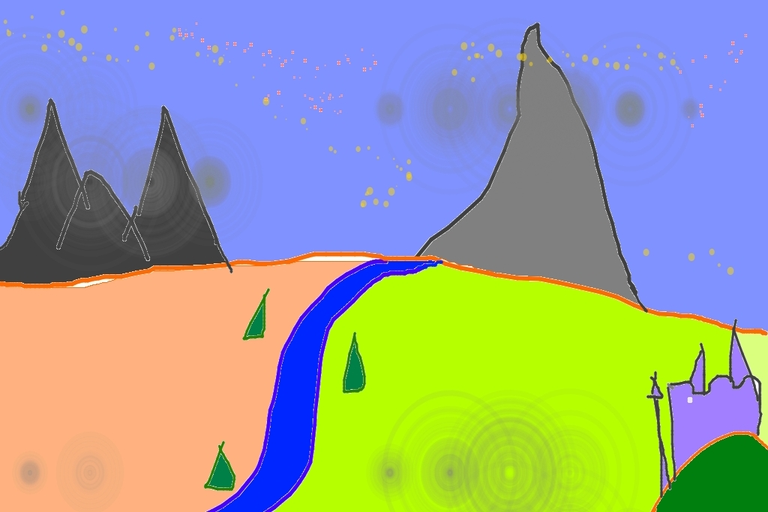

In [ ]:
import requests
from io import BytesIO

url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

# url 호출하기
response = requests.get(url)

# 이미지 열기
init_img = Image.open(BytesIO(response.content)).convert("RGB")  # 이미지를 메모리로 읽어와서 RGB로 변경합니다.
init_img = init_img.resize((768, 512))  # 이미지의 크기를 조절합니다.
init_img

In [ ]:
prompt = "A fantasy landscape, trending on artstation"

In [ ]:
generator = torch.Generator(device=device).manual_seed(1024)   # 모델을 사용할 때마다 동일한 이미지를 생성하기 위해 seed를 설정합니다.

images = pipe(prompt=prompt, image=init_img, strength=0.75, guidance_scale=7.5).images
images[0].save("/content/aiffel/aiffel/diffusers/fantasy_landscape.png")
images[0]

In [ ]:
num_images = 2

# 프롬프트 입력
prompt = ['A fantasy landscape, trending on artstation'] * num_images

# 이미지 생성
generator = torch.Generator(device=device).manual_seed(1024)
images = pipe(prompt=prompt, image=init_img, strength=0.9, guidance_scale=13.5, num_inference_steps=50, generator=generator).images
images

# 이미지 출력
grid = image_grid(images, rows=1, cols=2)
grid

# 프로젝트

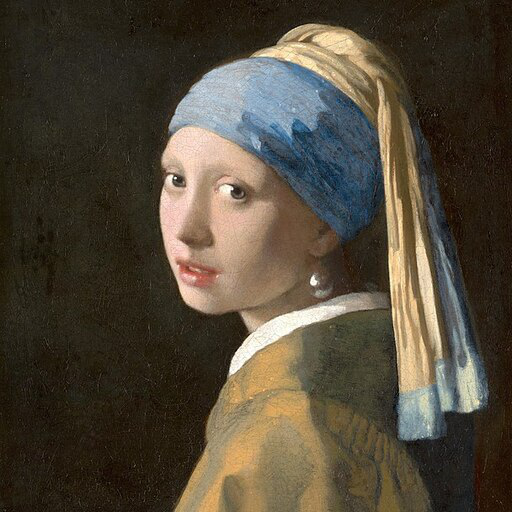

In [ ]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

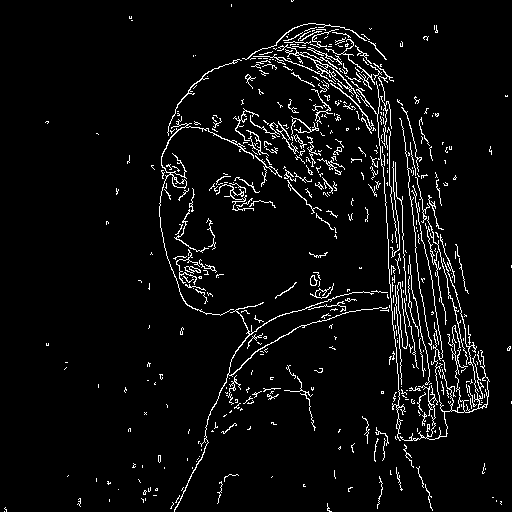

In [ ]:
import cv2
from PIL import Image
import numpy as np

# 이미지를 NumPy 배열로 변환합니다.
image = np.array(image)

# threshold를 지정합니다.
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다.
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다.

canny_image

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

In [ ]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 이미지를 생성합니다.
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights",
    num_inference_steps=20,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다.
canny_image.save("/content/aiffel/aiffel/canny_image.png")

# 생성된 이미지를 출력합니다.
canny_image

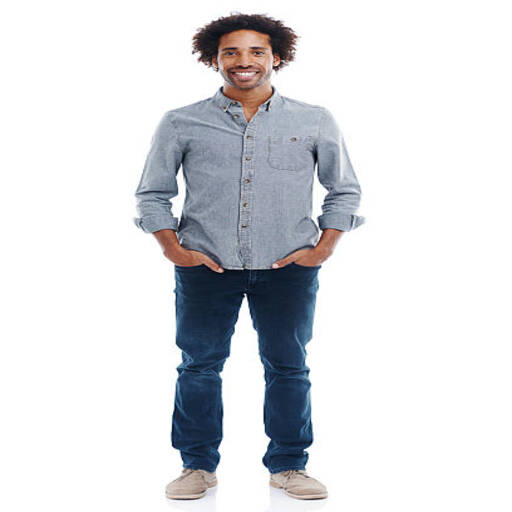

In [ ]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

/usr/local/lib/python3.11/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


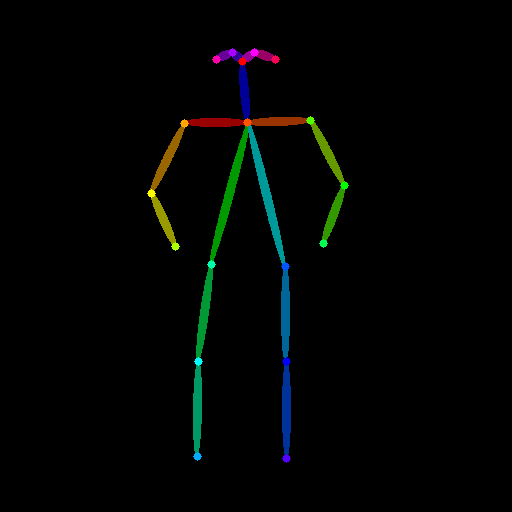

In [ ]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [ ]:
!pip install controlnet-aux

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

In [ ]:
from diffusers import UniPCMultistepScheduler
import torch

# 스케줄러 교체 & 모델을 CUDA로 이동
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# ✅ 동일한 이미지를 생성하기 위해 seed를 고정
generator = torch.manual_seed(0)

# ✅ 프롬프트 설정
prompt = "girl, ultra detailed, hairband, sunlight, 4k"
negative_prompt = "low quality, blurry, distorted, deformed"

# ✅ 이미지 생성
openpose_image1 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=1.0,   # 보통 0.5 ~ 2.0 사이에서 조정
    num_inference_steps=20,
    generator=generator,
    image=openpose_image                # ← OpenPose 조건 이미지 입력
).images[0]

# ✅ 이미지 출력
openpose_image1

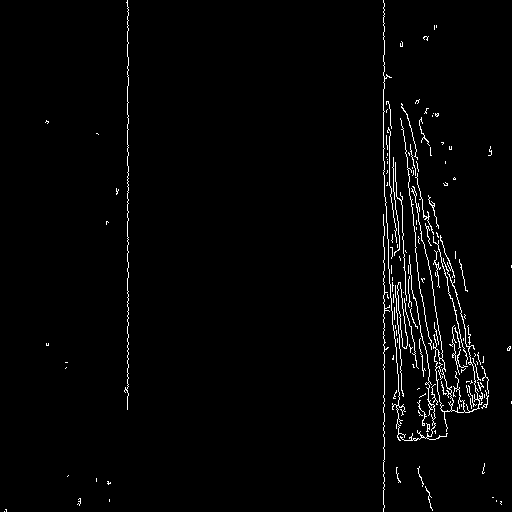

In [ ]:
from diffusers.utils import load_image
from PIL import Image
import cv2
import numpy as np

# ✅ 이미지를 불러옵니다 (예: URL 또는 경로)
canny_image = load_image("https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png")
canny_image = canny_image.resize((512, 512))  # 필요한 크기로 리사이즈

# ✅ threshold 값을 설정합니다
low_threshold = 100
high_threshold = 200

# ✅ 이미지를 NumPy 배열로 변환하고 GRAYSCALE로 변경
canny_image = np.array(canny_image.convert("L"))

# ✅ 가운데 영역을 지워줍니다 (조건 피처를 제거하는 용도)
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# ✅ Canny 엣지 검출
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)

# ✅ 다시 RGB로 변환
canny_image = np.stack([canny_image] * 3, axis=-1)

# ✅ NumPy 배열을 PIL 이미지로 변환
canny_image = Image.fromarray(canny_image)

# 결과 출력 (Colab이나 Jupyter에서는 바로 보여짐)
canny_image


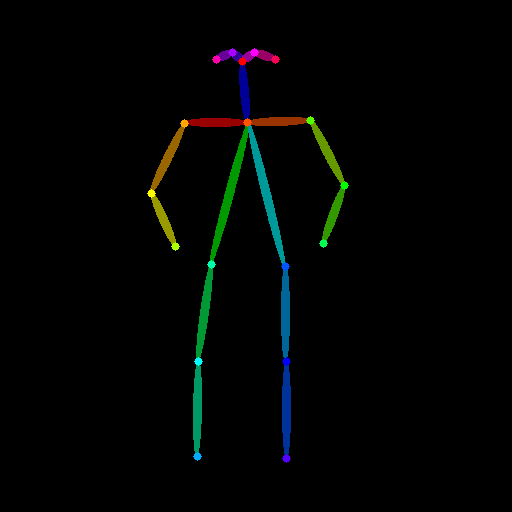

In [ ]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image

# ✅ 이미지를 불러옵니다 (예: URL 또는 로컬 경로)
openpose_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png")

# ✅ OpenPose Detector 초기화
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# ✅ 포즈 검출 (출력: PIL 이미지 형식의 pose map)
openpose_image = openpose(openpose_image)
openpose_image

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

# ✅ Edge Detection과 Openpose 두 개의 ControlNet 모델을 로드
controlnet_canny = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet_openpose = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)

# ✅ 두 모델을 리스트로 묶음
controlnets = [controlnet_openpose, controlnet_canny]

# ✅ 멀티 ControlNet 파이프라인 생성
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

# ✅ 스케줄러 및 CUDA 설정
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# ✅ 프롬프트 작성
prompt = "a western cowboy style fashion model, walking in city street, ultra detailed, 4k, trending on artstation"
negative_prompt = "blurry, distorted, low quality, extra limbs"

# ✅ seed 고정
generator = torch.manual_seed(0)

# ✅ ControlNet용 condition 이미지 순서대로 전달 (openpose, canny)
images = [openpose_image, canny_image]

# ✅ 이미지 생성
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    generator=generator,
    image=images,  # ControlNet condition 입력
    controlnet_conditioning_scale=[1.0, 0.8]  # 각 controlnet의 영향력 조절
).images[0]

# ✅ 이미지 저장
# image.save("aiffel/aiffel/multi_controlnet_output.png")

# ✅ 이미지 출력
image


In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

# ✅ Edge Detection과 Openpose 두 개의 ControlNet 모델을 로드
controlnet_canny = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet_openpose = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)

# ✅ 두 모델을 리스트로 묶음
controlnets = [controlnet_openpose, controlnet_canny]

# ✅ 멀티 ControlNet 파이프라인 생성
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

# ✅ 스케줄러 및 CUDA 설정
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# ✅ 프롬프트 작성
prompt = "a futuristic fashion model, walking in city street, ultra detailed, 4k, trending on artstation"
negative_prompt = "blurry, distorted, low quality, extra limbs"

# ✅ seed 고정
generator = torch.manual_seed(0)

# ✅ ControlNet용 condition 이미지 순서대로 전달 (openpose, canny)
images = [openpose_image, canny_image]

# ✅ 이미지 생성
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    generator=generator,
    image=images,  # ControlNet condition 입력
    controlnet_conditioning_scale=[1.0, 0.8]  # 각 controlnet의 영향력 조절
).images[0]

# ✅ 이미지 저장
# image.save("aiffel/aiffel/multi_controlnet_output.png")

# ✅ 이미지 출력
image


##후기

사진이 막 바뀌어서 생성되니까 약간 끔찍하기도 깜찍하기도 하면서 귀여웠다.
아쉬웠던 점은 내가 예상한 것과 다른 이미지..? ㅋㅋㅋ 근데 오히려 그래서 재밌었음.
어떤 루트로 학습해서 이미지를 생성하는지 모르겠는데,
어떻게 프롬프트를 잘 짜고 잘 학습시켜서 원하는 이미지를 도출해낼지 더 상세하게 학습해야겠다.